# MNIST 분류기 (CNN)

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [4]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [5]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [70]:
# CNN Model (2 conv layers)
# 수업 때 만든 모델

class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # Final FC 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)
        
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # Final FC 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)
        self.fc = torch.nn.Linear(1 * 1 * 256, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc(out)
        return out

In [111]:
# CNN Model (2 conv layers)
# 새로 구현해본 모델

class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 64)
        #    Pool     -> (?, 14, 14, 64)
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, 3,padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),           
            torch.nn.Conv2d(32, 64, 3,padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)        
        )

        self.layer2 = torch.nn.Sequential(
            torch.nn.Linear(64*7*7, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),            
            torch.nn.Linear(64, 10)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.layer2(out)
        return out

In [112]:
# instantiate CNN model
model = CNN().to(device)

In [113]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [114]:
%%time
# train my model
total_batch = len(data_loader)
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
[Epoch:    1] cost = 0.142990991
[Epoch:    2] cost = 0.0345072225
[Epoch:    3] cost = 0.0231655519
[Epoch:    4] cost = 0.0157478508
[Epoch:    5] cost = 0.0128072612
[Epoch:    6] cost = 0.0099572707
[Epoch:    7] cost = 0.00901374407
[Epoch:    8] cost = 0.00880189426
[Epoch:    9] cost = 0.00753822131
[Epoch:   10] cost = 0.00651610084
[Epoch:   11] cost = 0.00453394977
[Epoch:   12] cost = 0.00570481597
[Epoch:   13] cost = 0.00394764217
[Epoch:   14] cost = 0.00464485912
[Epoch:   15] cost = 0.00533371093
Learning Finished!
CPU times: user 1min 49s, sys: 1.01 s, total: 1min 50s
Wall time: 1min 49s


In [116]:
%%time
# Test model and check accuracy
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9927999973297119
CPU times: user 168 ms, sys: 2.02 ms, total: 170 ms
Wall time: 168 ms


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


# Metric Learning
SubCenterArcFaceLoss

In [117]:
!pip install pytorch-metric-learning -q
!pip install faiss-gpu -q

     |████████████████████████████████| 109 kB 8.0 MB/s 
     |████████████████████████████████| 85.5 MB 107 kB/s 


In [120]:
mm = models.resnet18()

In [121]:
mm

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [129]:
# SubCenterArcFaceLoss 를 사용했을 때

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models

from pytorch_metric_learning import losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        embeddings = model(data)
        loss = loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        loss_optimizer.step()
        if batch_idx % 100 == 0:
            print("Epoch {} Iteration {}: Loss = {}".format(epoch, batch_idx, loss))


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, train_embeddings, test_labels, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


device = torch.device("cuda")

img_mean, img_std = (0.1307,), (0.3081,)
normalize = transforms.Normalize(img_mean, img_std)
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])

transform = transforms.Compose(
    [transforms.ToTensor(), normalize]
)

batch_size = 128

dataset1 = datasets.MNIST(".", train=True, download=True, transform=transform)
dataset2 = datasets.MNIST(".", train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(
    dataset1, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)


num_classes = 128
# model = Net().to(device)

model = models.resnet18(True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0003)
num_epochs = 30

### pytorch-metric-learning stuff ###
loss_func = losses.SubCenterArcFaceLoss(num_classes=10, embedding_size=128).to(device)
loss_optimizer = torch.optim.Adam(loss_func.parameters(), lr=1e-4)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###

In [ ]:
# Triplet Margin Loss 를 사용했을 때

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models

from pytorch_metric_learning import losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        embeddings = model(data)
        loss = loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        loss_optimizer.step()
        if batch_idx % 100 == 0:
            print("Epoch {} Iteration {}: Loss = {}".format(epoch, batch_idx, loss))


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, train_embeddings, test_labels, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


device = torch.device("cuda")

img_mean, img_std = (0.1307,), (0.3081,)
normalize = transforms.Normalize(img_mean, img_std)
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])

transform = transforms.Compose(
    [transforms.ToTensor(), normalize]
)

batch_size = 128

dataset1 = datasets.MNIST(".", train=True, download=True, transform=transform)
dataset2 = datasets.MNIST(".", train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(
    dataset1, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)


num_classes = 128
# model = Net().to(device)

model = models.resnet18(True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0003)
num_epochs = 30

### pytorch-metric-learning stuff ###
loss_func = losses.TripletMarginLoss(margin=0.05,
                        swap=False,
                        smooth_loss=False,
                        triplets_per_anchor="all")

accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###

In [130]:
model.conv1

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

## Train the model

In [131]:
for epoch in range(1, num_epochs + 1):
    train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch)
    test(dataset1, dataset2, model, accuracy_calculator)

Epoch 1 Iteration 0: Loss = 0.1355334371328354
Epoch 1 Iteration 100: Loss = 0.12392473220825195
Epoch 1 Iteration 200: Loss = 0.07364806532859802
Epoch 1 Iteration 300: Loss = 0.05801565200090408
Epoch 1 Iteration 400: Loss = 0.05312956124544144


100%|██████████| 313/313 [00:03<00:00, 91.40it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9806
Epoch 2 Iteration 0: Loss = 0.0734800398349762
Epoch 2 Iteration 100: Loss = 0.06757699698209763
Epoch 2 Iteration 200: Loss = 0.06259521096944809
Epoch 2 Iteration 300: Loss = 0.08697433024644852
Epoch 2 Iteration 400: Loss = 0.06382335722446442


100%|██████████| 313/313 [00:03<00:00, 93.51it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9859
Epoch 3 Iteration 0: Loss = 0.07369870692491531
Epoch 3 Iteration 100: Loss = 0.03411443158984184
Epoch 3 Iteration 200: Loss = 0.06246872618794441
Epoch 3 Iteration 300: Loss = 0.043602168560028076
Epoch 3 Iteration 400: Loss = 0.0367787666618824


100%|██████████| 313/313 [00:03<00:00, 93.08it/s] 


Computing accuracy
Test set accuracy (Precision@1) = 0.9875
Epoch 4 Iteration 0: Loss = 0.06286850571632385
Epoch 4 Iteration 100: Loss = 0.06293131411075592
Epoch 4 Iteration 200: Loss = 0.06602448970079422
Epoch 4 Iteration 300: Loss = 0.07238438725471497
Epoch 4 Iteration 400: Loss = 0.047470055520534515


100%|██████████| 313/313 [00:03<00:00, 91.69it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9899
Epoch 5 Iteration 0: Loss = 0.041407857090234756
Epoch 5 Iteration 100: Loss = 0.050698086619377136
Epoch 5 Iteration 200: Loss = 0.03831321373581886
Epoch 5 Iteration 300: Loss = 0.035060472786426544
Epoch 5 Iteration 400: Loss = 0.06876079738140106


100%|██████████| 313/313 [00:03<00:00, 92.09it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9888
Epoch 6 Iteration 0: Loss = 0.018950456753373146
Epoch 6 Iteration 100: Loss = 0.0703633576631546
Epoch 6 Iteration 200: Loss = 0.06700006127357483
Epoch 6 Iteration 300: Loss = 0.035871971398591995
Epoch 6 Iteration 400: Loss = 0.08307555317878723


100%|██████████| 313/313 [00:03<00:00, 91.22it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9901000000000001
Epoch 7 Iteration 0: Loss = 0.04934489354491234
Epoch 7 Iteration 100: Loss = 0.04889639839529991
Epoch 7 Iteration 200: Loss = 0.00646629836410284
Epoch 7 Iteration 300: Loss = 0.027623344212770462
Epoch 7 Iteration 400: Loss = 0.05726194381713867


100%|██████████| 313/313 [00:03<00:00, 90.12it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9898
Epoch 8 Iteration 0: Loss = 0.013276447542011738
Epoch 8 Iteration 100: Loss = 0.015623806044459343
Epoch 8 Iteration 200: Loss = 0.017885448411107063
Epoch 8 Iteration 300: Loss = 0.09359629452228546
Epoch 8 Iteration 400: Loss = 0.10075844079256058


100%|██████████| 313/313 [00:03<00:00, 91.93it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9916
Epoch 9 Iteration 0: Loss = 0.008039827458560467
Epoch 9 Iteration 100: Loss = 0.05200833082199097
Epoch 9 Iteration 200: Loss = 0.05334389582276344
Epoch 9 Iteration 300: Loss = 0.05511011183261871
Epoch 9 Iteration 400: Loss = 0.057610828429460526


100%|██████████| 313/313 [00:03<00:00, 89.47it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9906
Epoch 10 Iteration 0: Loss = 0.004512710031121969
Epoch 10 Iteration 100: Loss = 0.13947351276874542
Epoch 10 Iteration 200: Loss = 0.08200957626104355
Epoch 10 Iteration 300: Loss = 0.0745633915066719
Epoch 10 Iteration 400: Loss = 0.09247253835201263


100%|██████████| 313/313 [00:03<00:00, 91.35it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9900000000000001
Epoch 11 Iteration 0: Loss = 0.03967167064547539
Epoch 11 Iteration 100: Loss = 0.04432215169072151
Epoch 11 Iteration 200: Loss = 0.04220917448401451
Epoch 11 Iteration 300: Loss = 0.07294539362192154
Epoch 11 Iteration 400: Loss = 0.0


100%|██████████| 313/313 [00:03<00:00, 90.18it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9913000000000001
Epoch 12 Iteration 0: Loss = 0.0
Epoch 12 Iteration 100: Loss = 0.0
Epoch 12 Iteration 200: Loss = 0.04610471427440643
Epoch 12 Iteration 300: Loss = 0.0
Epoch 12 Iteration 400: Loss = 0.027408169582486153


100%|██████████| 313/313 [00:03<00:00, 90.43it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9923000000000001
Epoch 13 Iteration 0: Loss = 0.03576448932290077
Epoch 13 Iteration 100: Loss = 0.0
Epoch 13 Iteration 200: Loss = 0.004115101415663958
Epoch 13 Iteration 300: Loss = 0.0
Epoch 13 Iteration 400: Loss = 0.045689549297094345


100%|██████████| 313/313 [00:03<00:00, 92.32it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9925
Epoch 14 Iteration 0: Loss = 0.018128905445337296
Epoch 14 Iteration 100: Loss = 0.0
Epoch 14 Iteration 200: Loss = 0.0
Epoch 14 Iteration 300: Loss = 0.020005404949188232
Epoch 14 Iteration 400: Loss = 0.06282325834035873


100%|██████████| 313/313 [00:03<00:00, 90.31it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9935
Epoch 15 Iteration 0: Loss = 0.0
Epoch 15 Iteration 100: Loss = 0.0
Epoch 15 Iteration 200: Loss = 0.005894239526242018
Epoch 15 Iteration 300: Loss = 0.002630389528349042
Epoch 15 Iteration 400: Loss = 0.02219984121620655


100%|██████████| 313/313 [00:03<00:00, 91.72it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9923000000000001
Epoch 16 Iteration 0: Loss = 0.0
Epoch 16 Iteration 100: Loss = 0.0
Epoch 16 Iteration 200: Loss = 0.0
Epoch 16 Iteration 300: Loss = 0.0
Epoch 16 Iteration 400: Loss = 0.0


100%|██████████| 313/313 [00:03<00:00, 91.57it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.992
Epoch 17 Iteration 0: Loss = 0.0033357329666614532
Epoch 17 Iteration 100: Loss = 0.05165370926260948
Epoch 17 Iteration 200: Loss = 0.08507315814495087
Epoch 17 Iteration 300: Loss = 0.0
Epoch 17 Iteration 400: Loss = 0.0055509875528514385


100%|██████████| 313/313 [00:03<00:00, 91.06it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9928
Epoch 18 Iteration 0: Loss = 0.10161349177360535
Epoch 18 Iteration 100: Loss = 0.0
Epoch 18 Iteration 200: Loss = 0.0948178619146347
Epoch 18 Iteration 300: Loss = 0.0
Epoch 18 Iteration 400: Loss = 0.04040868580341339


100%|██████████| 313/313 [00:03<00:00, 91.17it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9929
Epoch 19 Iteration 0: Loss = 0.0
Epoch 19 Iteration 100: Loss = 0.0
Epoch 19 Iteration 200: Loss = 0.0
Epoch 19 Iteration 300: Loss = 0.0
Epoch 19 Iteration 400: Loss = 0.07184059172868729


100%|██████████| 313/313 [00:03<00:00, 91.44it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9934000000000001
Epoch 20 Iteration 0: Loss = 0.0
Epoch 20 Iteration 100: Loss = 0.0
Epoch 20 Iteration 200: Loss = 0.0
Epoch 20 Iteration 300: Loss = 0.0
Epoch 20 Iteration 400: Loss = 0.0641002506017685


100%|██████████| 313/313 [00:03<00:00, 91.75it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9926
Epoch 21 Iteration 0: Loss = 0.011955888010561466
Epoch 21 Iteration 100: Loss = 0.0
Epoch 21 Iteration 200: Loss = 0.08399666845798492
Epoch 21 Iteration 300: Loss = 0.06435783207416534
Epoch 21 Iteration 400: Loss = 0.044072624295949936


100%|██████████| 313/313 [00:03<00:00, 91.41it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9936
Epoch 22 Iteration 0: Loss = 0.0
Epoch 22 Iteration 100: Loss = 0.018359044566750526
Epoch 22 Iteration 200: Loss = 0.004907321184873581
Epoch 22 Iteration 300: Loss = 0.0
Epoch 22 Iteration 400: Loss = 0.0


100%|██████████| 313/313 [00:03<00:00, 91.36it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9936
Epoch 23 Iteration 0: Loss = 0.0
Epoch 23 Iteration 100: Loss = 0.0015787668526172638
Epoch 23 Iteration 200: Loss = 0.05178701505064964
Epoch 23 Iteration 300: Loss = 0.0
Epoch 23 Iteration 400: Loss = 0.06039563566446304


100%|██████████| 313/313 [00:03<00:00, 91.95it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.994
Epoch 24 Iteration 0: Loss = 0.0
Epoch 24 Iteration 100: Loss = 0.0
Epoch 24 Iteration 200: Loss = 0.050923705101013184
Epoch 24 Iteration 300: Loss = 0.02430858463048935
Epoch 24 Iteration 400: Loss = 0.005774530116468668


100%|██████████| 313/313 [00:03<00:00, 92.15it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9932000000000001
Epoch 25 Iteration 0: Loss = 0.05912693217396736
Epoch 25 Iteration 100: Loss = 0.0
Epoch 25 Iteration 200: Loss = 0.0
Epoch 25 Iteration 300: Loss = 0.0218314491212368
Epoch 25 Iteration 400: Loss = 0.0


100%|██████████| 313/313 [00:03<00:00, 92.28it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9945
Epoch 26 Iteration 0: Loss = 0.0
Epoch 26 Iteration 100: Loss = 0.0
Epoch 26 Iteration 200: Loss = 0.0
Epoch 26 Iteration 300: Loss = 0.0
Epoch 26 Iteration 400: Loss = 0.005477047525346279


100%|██████████| 313/313 [00:03<00:00, 90.92it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9945
Epoch 27 Iteration 0: Loss = 0.0
Epoch 27 Iteration 100: Loss = 0.0
Epoch 27 Iteration 200: Loss = 0.0
Epoch 27 Iteration 300: Loss = 0.0
Epoch 27 Iteration 400: Loss = 0.0


100%|██████████| 313/313 [00:03<00:00, 92.72it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9943000000000001
Epoch 28 Iteration 0: Loss = 0.10821446031332016
Epoch 28 Iteration 100: Loss = 0.0
Epoch 28 Iteration 200: Loss = 0.0
Epoch 28 Iteration 300: Loss = 0.09628567099571228
Epoch 28 Iteration 400: Loss = 0.1466526836156845


100%|██████████| 313/313 [00:03<00:00, 93.15it/s] 


Computing accuracy
Test set accuracy (Precision@1) = 0.9939
Epoch 29 Iteration 0: Loss = 0.08992348611354828
Epoch 29 Iteration 100: Loss = 0.13782048225402832
Epoch 29 Iteration 200: Loss = 0.0
Epoch 29 Iteration 300: Loss = 0.03235297277569771
Epoch 29 Iteration 400: Loss = 0.025805097073316574


100%|██████████| 313/313 [00:03<00:00, 92.24it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9948
Epoch 30 Iteration 0: Loss = 0.0
Epoch 30 Iteration 100: Loss = 0.0
Epoch 30 Iteration 200: Loss = 0.0
Epoch 30 Iteration 300: Loss = 0.0
Epoch 30 Iteration 400: Loss = 0.09290525317192078


100%|██████████| 313/313 [00:03<00:00, 92.08it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9938


### Get outliers

In [132]:
train_embeddings, train_labels = get_all_embeddings(dataset1, model)

100%|██████████| 1875/1875 [00:21<00:00, 87.97it/s]


In [ ]:
outliers, _ = loss_func.get_outliers(train_embeddings, train_labels.squeeze(1))
print(f"There are {len(outliers)} outliers")

### View some sample outliers

In [134]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(img_mean, img_std)], std=[1 / s for s in img_std]
)


def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def imshow_many(dataset, outliers, n=32):
    imgs = [
        dataset[outliers[i]][0]
        for i in np.random.choice(
            len(outliers), size=min(n, len(outliers)), replace=False
        )
    ]
    imshow(torchvision.utils.make_grid(imgs))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


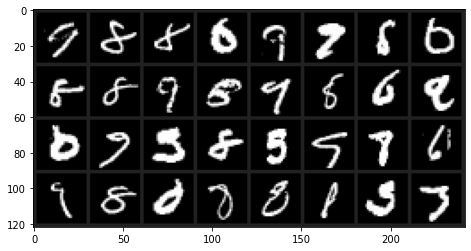

In [127]:
# let's see what outliers are.
# these are the samples that >threshold degrees aways from their dominant centers
imshow_many(dataset1, outliers)